In [1]:
from geopy.distance import geodesic
import partridge as pt
import pandas as pd
from meteostat import Point as MeteoPoint, Hourly as MeteoHourly
from datetime import datetime
import data_processing as dp
import geopandas as gpd
from shapely.geometry import Point as GeoPoint

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from datetime import timedelta, time



In [2]:
feed = pt.load_feed("gtfs")

# Inspect key tables
stops = feed.stops
stop_times = feed.stop_times
routes = feed.routes
trips = feed.trips


In [3]:
feed.feed_info

,feed_publisher_name,feed_publisher_url,feed_lang,feed_start_date,feed_end_date,feed_version,feed_contact_email
0,MBTA,http://www.mbta.com,EN,2022-12-29,2023-03-11,"Winter 2023, 2023-01-05T00:13:26+00:00, version D",developer@mbta.com


In [4]:
print("Stops Table:\n", stops.head())


Stops Table:
   stop_id stop_code                      stop_name stop_desc platform_code  \
0       1         1   Washington St opp Ruggles St       NaN           NaN   
1      10        10  Theo Glynn Way @ Newmarket Sq       NaN           NaN   
2   10000     10000       Tremont St opp Temple Pl       NaN           NaN   
3   10003     10003       Albany St opp Randall St       NaN           NaN   
4   10005     10005     Albany St opp E Concord St       NaN           NaN   

  platform_name   stop_lat   stop_lon              zone_id stop_address  \
0           NaN  42.330957 -71.082754  ExpressBus-Downtown          NaN   
1           NaN  42.330555 -71.068787             LocalBus          NaN   
2           NaN  42.355692 -71.062911             LocalBus          NaN   
3           NaN  42.331591 -71.076237             LocalBus          NaN   
4           NaN  42.335017 -71.071280             LocalBus          NaN   

                           stop_url level_id  location_type parent

In [5]:
bike_data = pd.read_csv('data/boston/202301-bluebikes-tripdata.csv')
boston = MeteoPoint(42.3601, -71.0589)  # Latitude and Longitude for Boston
start = datetime(2023, 1, 1)
end = datetime(2023, 1, 31)

weather_data_hourly = MeteoHourly(boston, start, end)
weather_data_hourly = weather_data_hourly.fetch()


In [6]:
weather_data_hourly = weather_data_hourly.reset_index()
bike_data['starttime'] = pd.to_datetime(bike_data['starttime'])
weather_data_hourly['time'] = pd.to_datetime(weather_data_hourly['time'])

bike_weather_data = pd.merge_asof(bike_data, weather_data_hourly, left_on='starttime', right_on='time', direction='nearest')


In [7]:
bike_weather_data = bike_weather_data.drop(columns=['snow', 'wpgt', 'tsun'])
bike_weather_data = dp.distance_feature(bike_weather_data)
bike_weather_data = dp.speed_feature(bike_weather_data)
bike_weather_data = dp.date_related_features(bike_weather_data)

## Mass Transit data features

### Frequencies feature

In [8]:
# Create geometry columns for start and end stations
bike_weather_data['start_geometry'] = bike_weather_data.apply(
    lambda x: GeoPoint(x['start station longitude'], x['start station latitude']), axis=1
)
bike_weather_data['end_geometry'] = bike_weather_data.apply(
    lambda x: GeoPoint(x['end station longitude'], x['end station latitude']), axis=1
)


In [9]:
# Convert bike_weather_data to a GeoDataFrame using start_geometry as the default geometry
bike_gdf = gpd.GeoDataFrame(bike_weather_data, geometry='start_geometry')


In [10]:
stops.columns

Index(['stop_id', 'stop_code', 'stop_name', 'stop_desc', 'platform_code',
       'platform_name', 'stop_lat', 'stop_lon', 'zone_id', 'stop_address',
       'stop_url', 'level_id', 'location_type', 'parent_station',
       'wheelchair_boarding', 'municipality', 'on_street', 'at_street',
       'vehicle_type'],
      dtype='object')

In [11]:
# Convert stops DataFrame to a GeoDataFrame
stops['geometry'] = stops.apply(lambda x: GeoPoint(x['stop_lon'], x['stop_lat']), axis=1)
stops_gdf = gpd.GeoDataFrame(stops, geometry='geometry')

# Keep only the columns we need
stops_gdf = stops_gdf[['stop_id', 'geometry']]

In [12]:
# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
bike_gdf.set_crs(epsg=4326, inplace=True)
stops_gdf.set_crs(epsg=4326, inplace=True)

# Convert CRS to a projection that allows distance calculations in meters (EPSG:3857)
stops_gdf = stops_gdf.to_crs(epsg=3857)
bike_gdf = bike_gdf.to_crs(epsg=3857)


In [13]:
radius = 500  # Example radius in meters
bike_gdf['buffer'] = bike_gdf.geometry.buffer(radius)
# Spatial joins to count nearby stops
start_station_nearby = gpd.sjoin(stops_gdf, bike_gdf.set_geometry('buffer'), how='inner', predicate='within')

# Set end_geometry as the active geometry
bike_gdf.set_geometry('end_geometry', inplace=True) 
bike_gdf = bike_gdf.set_crs(epsg=4326, inplace=True).to_crs(epsg=3857)

bike_gdf['buffer'] = bike_gdf.geometry.buffer(radius)
end_station_nearby = gpd.sjoin(stops_gdf, bike_gdf.set_geometry('buffer'), how='inner', predicate='within')


In [14]:
end_station_nearby.columns

Index(['stop_id', 'geometry', 'index_right', 'tripduration', 'starttime',
       'stoptime', 'start station id', 'start station name',
       'start station latitude', 'start station longitude', 'end station id',
       'end station name', 'end station latitude', 'end station longitude',
       'bikeid', 'usertype', 'postal code', 'time', 'temp', 'dwpt', 'rhum',
       'prcp', 'wdir', 'wspd', 'pres', 'coco', 'distance', 'speed',
       'start_hour', 'start_dayofweek', 'start_month', 'end_hour',
       'end_dayofweek', 'end_month', 'start_geometry', 'end_geometry'],
      dtype='object')

In [15]:
# Count the number of nearby stops for each unique start and end station
start_station_nearby_counts = start_station_nearby.groupby('index_right').size()
end_station_nearby_counts = end_station_nearby.groupby('index_right').size()

# Add the counts back to the original bike_weather_data
bike_weather_data['start_station_nearby_stations'] = bike_weather_data.index.map(start_station_nearby_counts).fillna(0).astype(int)
bike_weather_data['end_station_nearby_stations'] = bike_weather_data.index.map(end_station_nearby_counts).fillna(0).astype(int)



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



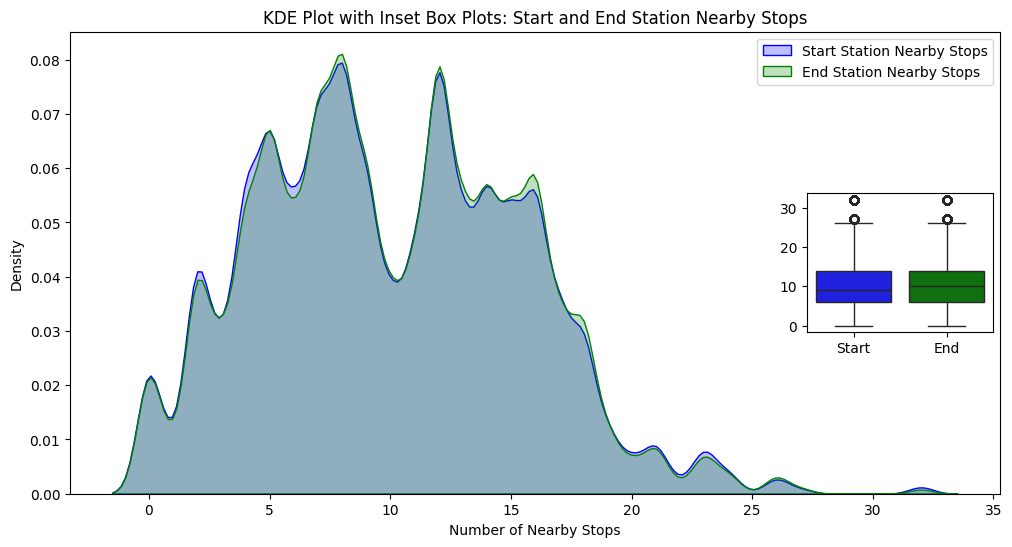

In [16]:
# Set up the main figure and axes
fig, main_ax = plt.subplots(figsize=(12, 6))

# KDE plots on the main axis
sns.kdeplot(bike_weather_data['start_station_nearby_stations'], ax=main_ax, color='blue', shade=True, label='Start Station Nearby Stops')
sns.kdeplot(bike_weather_data['end_station_nearby_stations'], ax=main_ax, color='green', shade=True, label='End Station Nearby Stops')

main_ax.set_title('KDE Plot with Inset Box Plots: Start and End Station Nearby Stops')
main_ax.set_xlabel('Number of Nearby Stops')
main_ax.set_ylabel('Density')
main_ax.legend()

# Create inset axes for the box plot
inset_ax = inset_axes(main_ax, width="20%", height="30%", loc='right')  # Adjust size and position as needed

# Box plots on the inset axis
sns.boxplot(data=[
    bike_weather_data['start_station_nearby_stations'], 
    bike_weather_data['end_station_nearby_stations']
], ax=inset_ax, palette=['blue', 'green'])

# Remove x-axis labels from the inset box plot for a cleaner look
inset_ax.set_xticklabels(['Start', 'End'])
inset_ax.set_xlabel('')
inset_ax.set_ylabel('')

plt.show()


In [17]:
print(bike_weather_data[['start_station_nearby_stations', 'end_station_nearby_stations']].head())


   start_station_nearby_stations  end_station_nearby_stations
0                             15                            8
1                              9                           14
2                              9                           14
3                              1                           12
4                             11                           20


In [18]:
q1 = bike_weather_data['start_station_nearby_stations'].quantile(0.25)
q2 = bike_weather_data['start_station_nearby_stations'].quantile(0.75)
print(q1, q2)

6.0 14.0


In [19]:
# Define thresholds for categorization based on the quantiles and encode directly
def encode_nearby_stops(count):
    if count <= 5:
        return 0  # 0 = Badly Connected
    elif 6 <= count <= 15:
        return 1  # 1 = Moderately Connected
    else:
        return 2  # 2 = Well Connected

# Apply encoding to both features
bike_weather_data['start_station_connection_encoded'] = bike_weather_data['start_station_nearby_stations'].apply(encode_nearby_stops)
bike_weather_data['end_station_connection_encoded'] = bike_weather_data['end_station_nearby_stations'].apply(encode_nearby_stops)


In [20]:
bike_weather_data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,start_month,end_hour,end_dayofweek,end_month,start_geometry,end_geometry,start_station_nearby_stations,end_station_nearby_stations,start_station_connection_encoded,end_station_connection_encoded
0,250,2023-01-01 00:02:54.080,2023-01-01 00:07:04.4100,36,Copley Square - Dartmouth St at Boylston St,42.349928,-71.077392,21,Prudential Center - 101 Huntington Ave,42.346520,...,1,0,6,1,POINT (-71.07739206866427 42.34992828230057),POINT (-71.08065776545118 42.34652003998412),15,8,1,1
1,489,2023-01-01 00:10:33.310,2023-01-01 00:18:42.3690,372,Boylston St at Exeter St,42.349589,-71.079468,404,Mass Ave T Station,42.341356,...,1,0,6,1,POINT (-71.0794677917329 42.349589423682445),POINT (-71.08336953450817 42.34135615767354),9,14,1,1
2,461,2023-01-01 00:10:49.913,2023-01-01 00:18:31.1280,372,Boylston St at Exeter St,42.349589,-71.079468,404,Mass Ave T Station,42.341356,...,1,0,6,1,POINT (-71.0794677917329 42.349589423682445),POINT (-71.08336953450817 42.34135615767354),9,14,1,1
3,1065,2023-01-01 00:13:58.064,2023-01-01 00:31:43.5090,58,Mugar Way at Beacon St,42.355536,-71.072869,345,Park Plaza at Charles St S.,42.351828,...,1,0,6,1,POINT (-71.07286870479584 42.35553628489709),POINT (-71.06781138111728 42.35182806892068),1,12,0,1
4,601,2023-01-01 00:14:02.613,2023-01-01 00:24:03.8950,50,Boylston St at Berkeley St,42.351142,-71.073292,374,Tremont St at Hamilton Pl,42.356683,...,1,0,6,1,POINT (-71.07329249382019 42.3511419825475),POINT (-71.06166645884514 42.35668334969929),11,20,1,2


In [21]:
bike_weather_data.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'postal code', 'time', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd',
       'pres', 'coco', 'distance', 'speed', 'start_hour', 'start_dayofweek',
       'start_month', 'end_hour', 'end_dayofweek', 'end_month',
       'start_geometry', 'end_geometry', 'start_station_nearby_stations',
       'end_station_nearby_stations', 'start_station_connection_encoded',
       'end_station_connection_encoded'],
      dtype='object')

## Transit Frequency

We processed the mass transit dataset using a relational database approach, linking tables like stops, stop_times, trips, and calendar through unique identifiers such as stop_id, trip_id, and service_id. By iterating through calendar data, we generated all relevant service dates, then merged these with trips and stop_times to create a complete arrival_time that combines the correct date and time. This ensured accurate temporal alignment for analyzing transit schedules alongside bike-sharing data.

In [22]:
# Step 2: Convert 'arrival_time' from seconds to time format
def convert_seconds_to_time(seconds):
    try:
        seconds = int(seconds)
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60
        seconds = seconds % 60
        # Normalize hours if they exceed 23 (e.g., "24:10:00" becomes "00:10:00")
        if hours >= 24:
            hours -= 24
        return time(hours, minutes, seconds)
    except (ValueError, TypeError):
        return None

stop_times['arrival_time'] = stop_times['arrival_time'].apply(convert_seconds_to_time)


In [23]:
stops = feed.stops
stop_times = feed.stop_times
trips = feed.trips
calendar = feed.calendar

# Step 2: Process calendar.txt to create a list of service dates
service_dates = []

# Convert 'start_date' and 'end_date' to datetime objects using pd.to_datetime
calendar['start_date'] = pd.to_datetime(calendar['start_date'], format='%Y%m%d')
calendar['end_date'] = pd.to_datetime(calendar['end_date'], format='%Y%m%d')

# Iterate through each row in the calendar to generate dates for each service_id
for index, row in calendar.iterrows():
    start_date = row['start_date']
    end_date = row['end_date']
    
    # Generate all dates between start_date and end_date
    current_date = start_date
    while current_date <= end_date:
        # Check if the service operates on the current day of the week
        day_of_week = current_date.strftime('%A').lower()
        if row[day_of_week] == 1:  # 1 means service operates on this day
            service_dates.append({
                'service_id': row['service_id'],
                'date': current_date
            })
        current_date += timedelta(days=1)



In [24]:
# Convert service_dates to a DataFrame
service_dates_df = pd.DataFrame(service_dates)

# Join service_dates with trips to associate dates with trips
trips_with_dates = trips.merge(service_dates_df, on='service_id')
trips_with_dates = trips_with_dates[['service_id' ,'trip_id', 'date']]

# Join with stop_times to create full arrival times
stop_times_with_dates = stop_times.merge(trips_with_dates, on='trip_id')


In [25]:
# Convert 'date' to a string and then combine with 'arrival_time' to create a full datetime
stop_times_with_dates['arrival_time'] = pd.to_datetime(
    stop_times_with_dates['date'].astype(str) + ' ' + stop_times_with_dates['arrival_time'].astype(str),
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'
)

In [26]:
stop_times_with_dates.columns

Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'stop_headsign', 'pickup_type', 'drop_off_type', 'timepoint',
       'checkpoint_id', 'continuous_pickup', 'continuous_drop_off',
       'service_id', 'date'],
      dtype='object')

In [27]:
stop_times_with_dates = stop_times_with_dates[['arrival_time', 'stop_id']]

### Transit Trips Before Start

Number of mass transit trips within a 500-meter radius and 15 minutes before the bike ride starts. This feature captures the potential for users to have used public transit as a feeder to the bike ride.

In [28]:
bike_gdf.set_geometry('start_geometry', inplace=True) 

radius = 500  # 500 meters
bike_gdf['buffer'] = bike_gdf.geometry.buffer(radius)

# Perform a spatial join to find stops within the buffer
stops_near_bike = gpd.sjoin(stops_gdf, bike_gdf.set_geometry('buffer'), how='inner', predicate='within')


In [29]:
stops_near_bike.columns

Index(['stop_id', 'geometry', 'index_right', 'tripduration', 'starttime',
       'stoptime', 'start station id', 'start station name',
       'start station latitude', 'start station longitude', 'end station id',
       'end station name', 'end station latitude', 'end station longitude',
       'bikeid', 'usertype', 'postal code', 'time', 'temp', 'dwpt', 'rhum',
       'prcp', 'wdir', 'wspd', 'pres', 'coco', 'distance', 'speed',
       'start_hour', 'start_dayofweek', 'start_month', 'end_hour',
       'end_dayofweek', 'end_month', 'start_geometry', 'end_geometry'],
      dtype='object')

In [ ]:
stops_near_bike = stops_near_bike[['stop_id', 'starttime', 'stoptime', 'bikeid']]

: 

In [ ]:
stops_near_bike['starttime'] = pd.to_datetime(stops_near_bike['starttime'])
stop_times_with_dates['arrival_time'] = pd.to_datetime(stop_times_with_dates['arrival_time'])

merged_data = stops_near_bike.merge(stop_times_with_dates, on='stop_id', how='inner')

# Filter for entries where the transit arrival time is within 15 minutes before the bike trip's start time
merged_data['time_diff'] = merged_data['starttime'] - merged_data['arrival_time']
filtered_data = merged_data[(merged_data['time_diff'] > timedelta(0)) & (merged_data['time_diff'] <= timedelta(minutes=15))]

counts = filtered_data.groupby('bikeid').size()
bike_weather_data['transit_trips_before_start'] = bike_weather_data.index.map(counts).fillna(0).astype(int)
